In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob
%matplotlib inline

In [24]:
ls

camera_cal/               example_writeup.pdf         project_video.mp4
Camera Calibration.ipynb  Experimenting.ipynb         README.md
camera_calibration.p      harder_challenge_video.mp4  test_images/
challenge_video.mp4       Image_Gen.ipynb             writeup_template.md
examples/                 output_images/


In [25]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']


In [26]:
ls camera_cal/

calibration10.jpg  calibration15.jpg  calibration1.jpg   calibration5.jpg
calibration11.jpg  calibration16.jpg  calibration20.jpg  calibration6.jpg
calibration12.jpg  calibration17.jpg  calibration2.jpg   calibration7.jpg
calibration13.jpg  calibration18.jpg  calibration3.jpg   calibration8.jpg
calibration14.jpg  calibration19.jpg  calibration4.jpg   calibration9.jpg


In [27]:
img = mpimg.imread('camera_cal/calibration1.jpg')

#### Show effect of undistortion

In [28]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

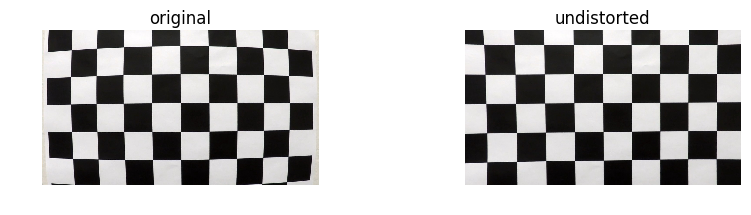

In [29]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off');
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('undistorted')
plt.axis('off');

### Function definitions

Sobel

In [30]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

Magnitude of the gradient

In [31]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel x and y
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)

    sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    print('sobel_xy: ', sobel_xy)
    print(':: ',np.max(sobel_xy, axis = 0))
    print('sobel_xy: ', sobel_xy.shape)
    sf = np.max(sobel_xy/255)
    gradmag = (sobel_xy/sf).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

Direction of the gradient

In [32]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_x= np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    
    
    direction = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

#### Color gradient

color gradient selection

In [33]:
def color_threshold(img, sthresh=(0, 255), vthresh = (0, 255)):
    """
    This function takes in two thresholds, s in HLS and v in HSV and the image and it 
    returns the combination output binary of both gradients
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    
    # s channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > sthresh[0]) & (s <= sthresh[1])] = 1
    
    # v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # isolate v channel
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > vthresh[0]) & (v <= vthresh[1])] = 1

    # create combination of both binaries as output
    output_binary = np.zeros_like(s)
    output_binary[(s_binary == 1) | (v_binary == 1)] = 255

    return output_binary

#### Perspective Transform

#### Color Mask

#### Combine masks

#### Sobel Filters

In [34]:
cd test_images/

/home/jj/Documents/Advanced-Lane-Lines/CarND-Advanced-Lane-Lines/test_images


In [35]:
rm tracked*

In [36]:
ls

straight_lines1.jpg  test1.jpg  test3.jpg  test5.jpg
straight_lines2.jpg  test2.jpg  test4.jpg  test6.jpg


In [37]:
cd ..

/home/jj/Documents/Advanced-Lane-Lines/CarND-Advanced-Lane-Lines


In [38]:
pwd

'/home/jj/Documents/Advanced-Lane-Lines/CarND-Advanced-Lane-Lines'

In [39]:
test_images_created = False

In [40]:
if test_images_created is False:
    for idx, fname in enumerate(glob.glob('test_images/*.jpg')):
        # read in the image
        img = cv2.imread(fname)
        
        # undistort the image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # preprocessing

        # grab single channel of the image
        preprocessImage = np.zeros_like(img[:,:,0])

        # apply sobel gradient x thresholds
        gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)

        # apply sobel gradient y thresholds
        grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)

        # apply color gradient threshold
        c_binary = color_threshold(img, sthresh = (100, 255), vthresh=(50, 255))


        
        # apply all three thresholds to preprocessImage and set true's to 1
        preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 150

        write_name = './test_images/tracked' + str(idx) + '.jpg'
        result = preprocessImage
        cv2.imwrite(write_name, result)
test_images_created = True

    

### Show postprocessed results

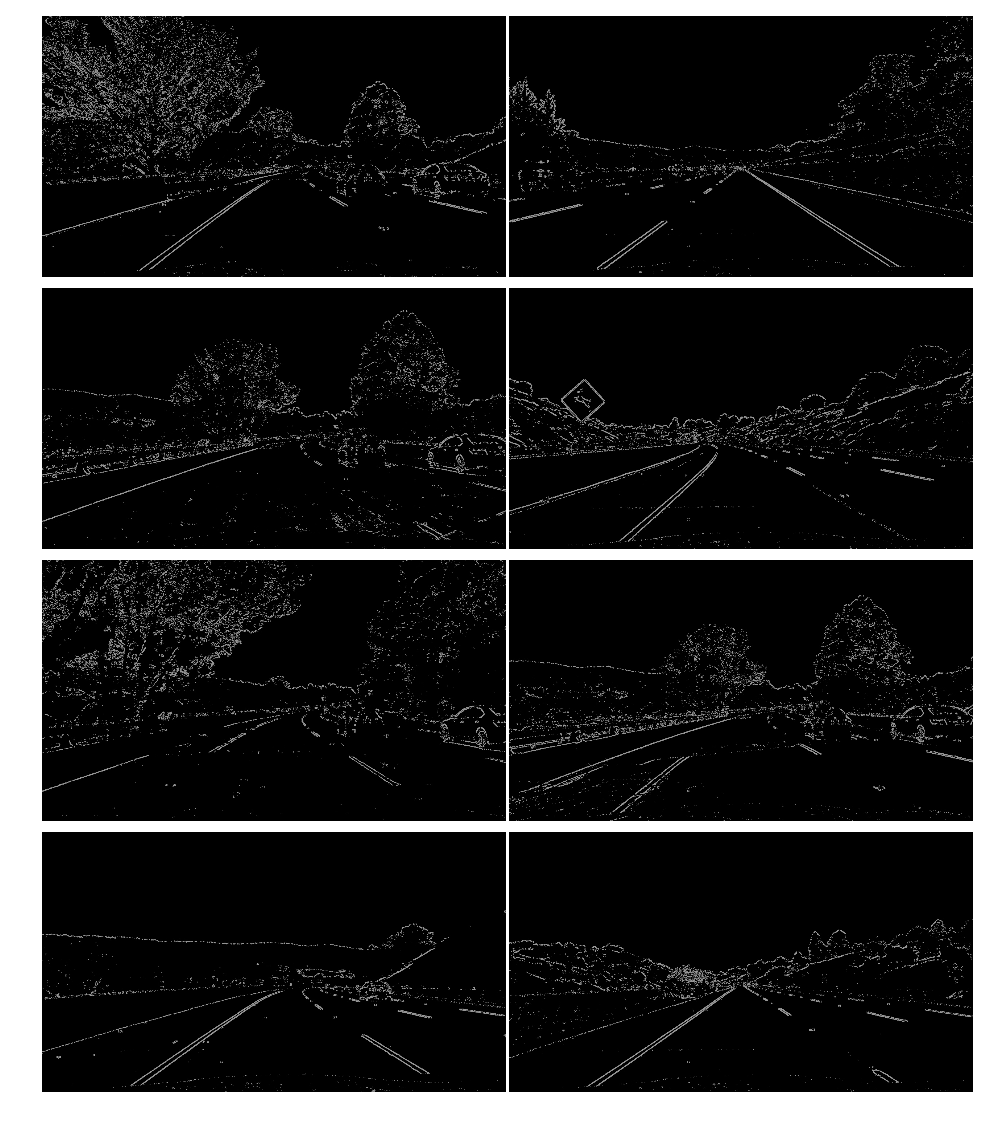

In [41]:
plt.figure(figsize=(12,14))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace = 0.01, hspace = 0.01)
    
for idx, fname in enumerate(glob.glob('test_images/tracked*.jpg')):
#     print('idx: ', idx) 15
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.imshow(img)
plt.show()


#### Window Creation

#### random images

img shape:  (720, 1280, 3)


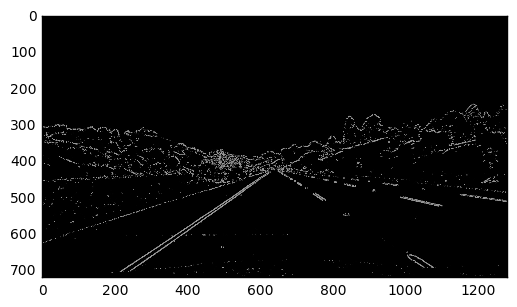

In [42]:
img = cv2.imread('test_images/tracked0.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)

print('img shape: ', image.shape)

##### Method 1
* Use hard-coded source points

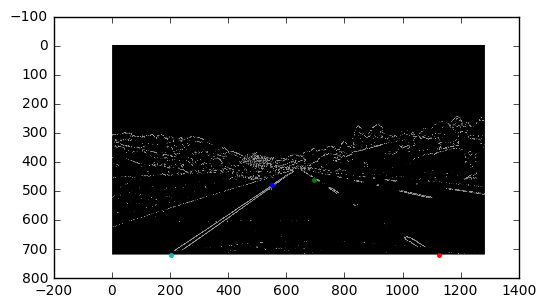

In [43]:
top_left_src = [550, 480]
top_right_src = [695, 460]
bot_left_src = [203, 720]
bot_right_src = [1127, 720]
plt.imshow(image)
plt.plot(top_left_src[0],top_left_src[1], '.')
plt.plot(top_right_src[0], top_right_src[1], '.')
plt.plot(bot_right_src[0], bot_right_src[1], '.')
plt.plot(bot_left_src[0], bot_left_src[1], '.')

src = np.float32([top_left_src, top_right_src, bot_right_src, bot_left_src])

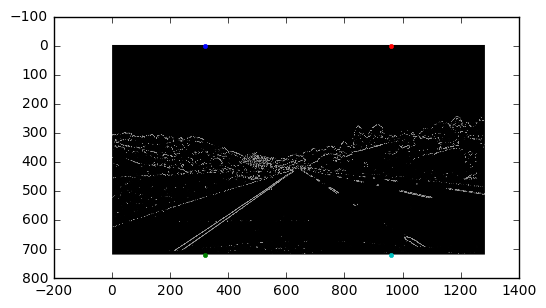

In [44]:
top_left_dst = [320, 0]
top_right_dst = [320, 720]
bot_left_dst = [960, 0]
bot_right_dst = [960, 720]
plt.imshow(image)
plt.plot(top_left_dst[0], top_left_dst[1], '.')
plt.plot(top_right_dst[0], top_right_dst[1], '.')
plt.plot(bot_left_dst[0], bot_left_dst[1], '.')
plt.plot(bot_right_dst[0], bot_right_dst[1], '.')

dest = np.float32([top_left_dst, top_right_dst, bot_right_dst, bot_left_dst])

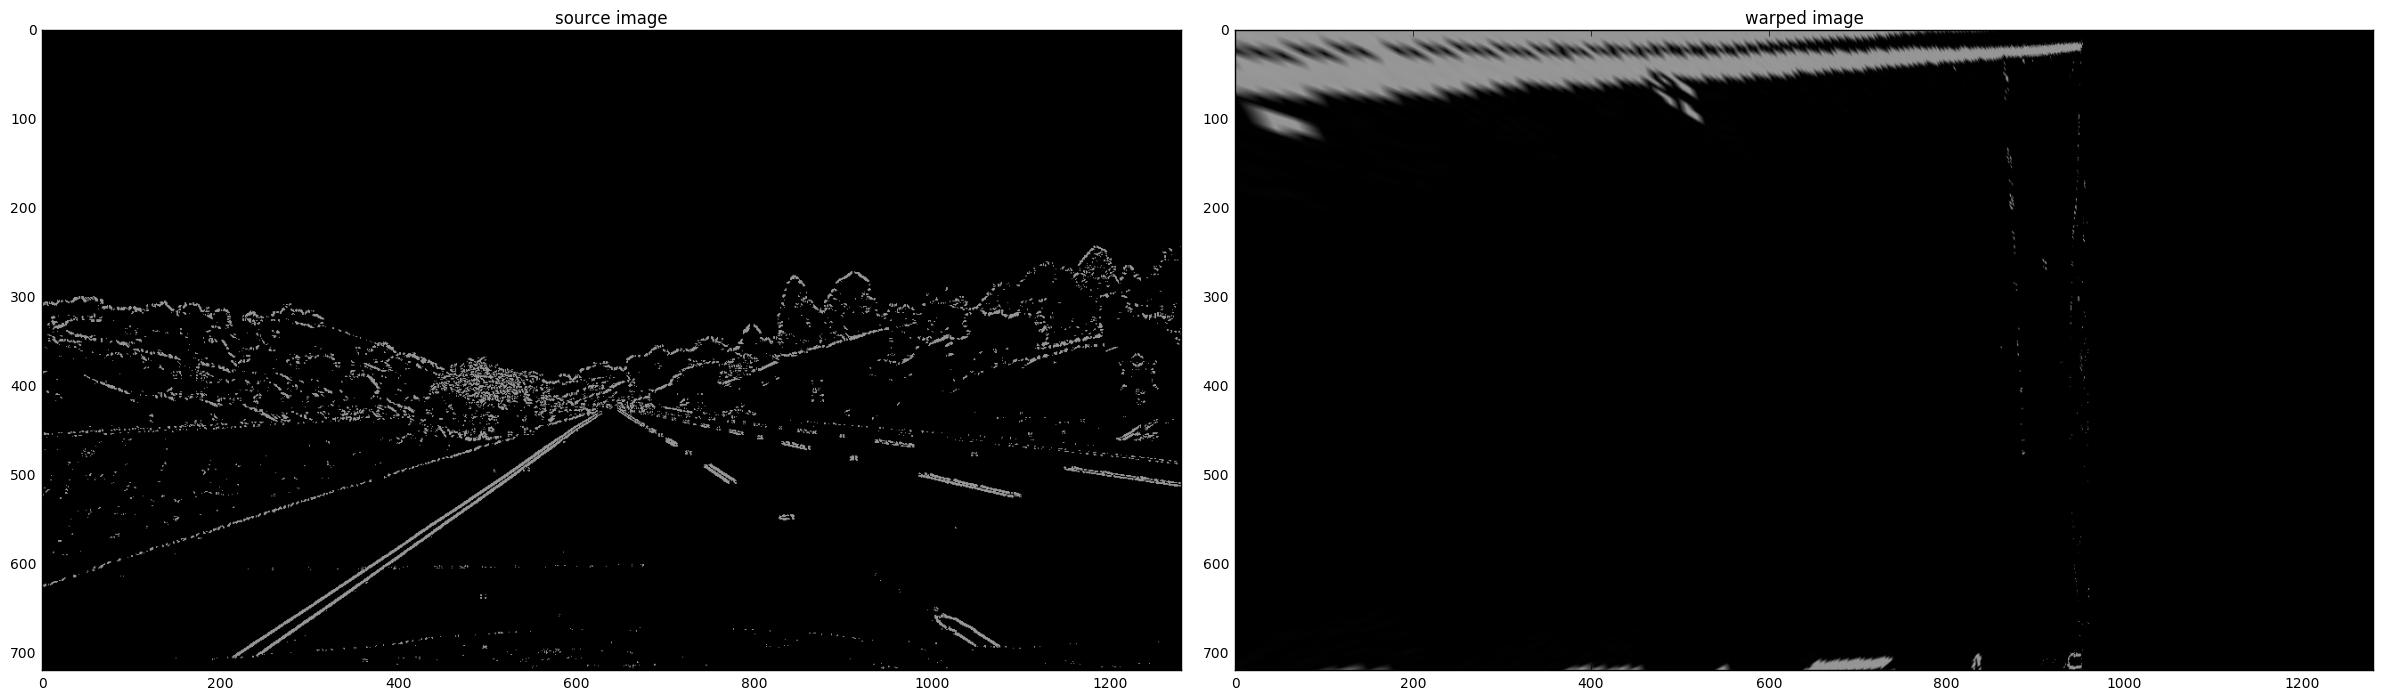

In [45]:
# build transformation matrix M
M = cv2.getPerspectiveTransform(src, dest) # get perspective transform
# IM = cv2.getPerspectiveTransform(dest, src) # get inverse perspective transform

warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()



ax1.set_title('source image')
ax1.imshow(image)
ax2.set_title('warped image')
ax2.imshow(warped)

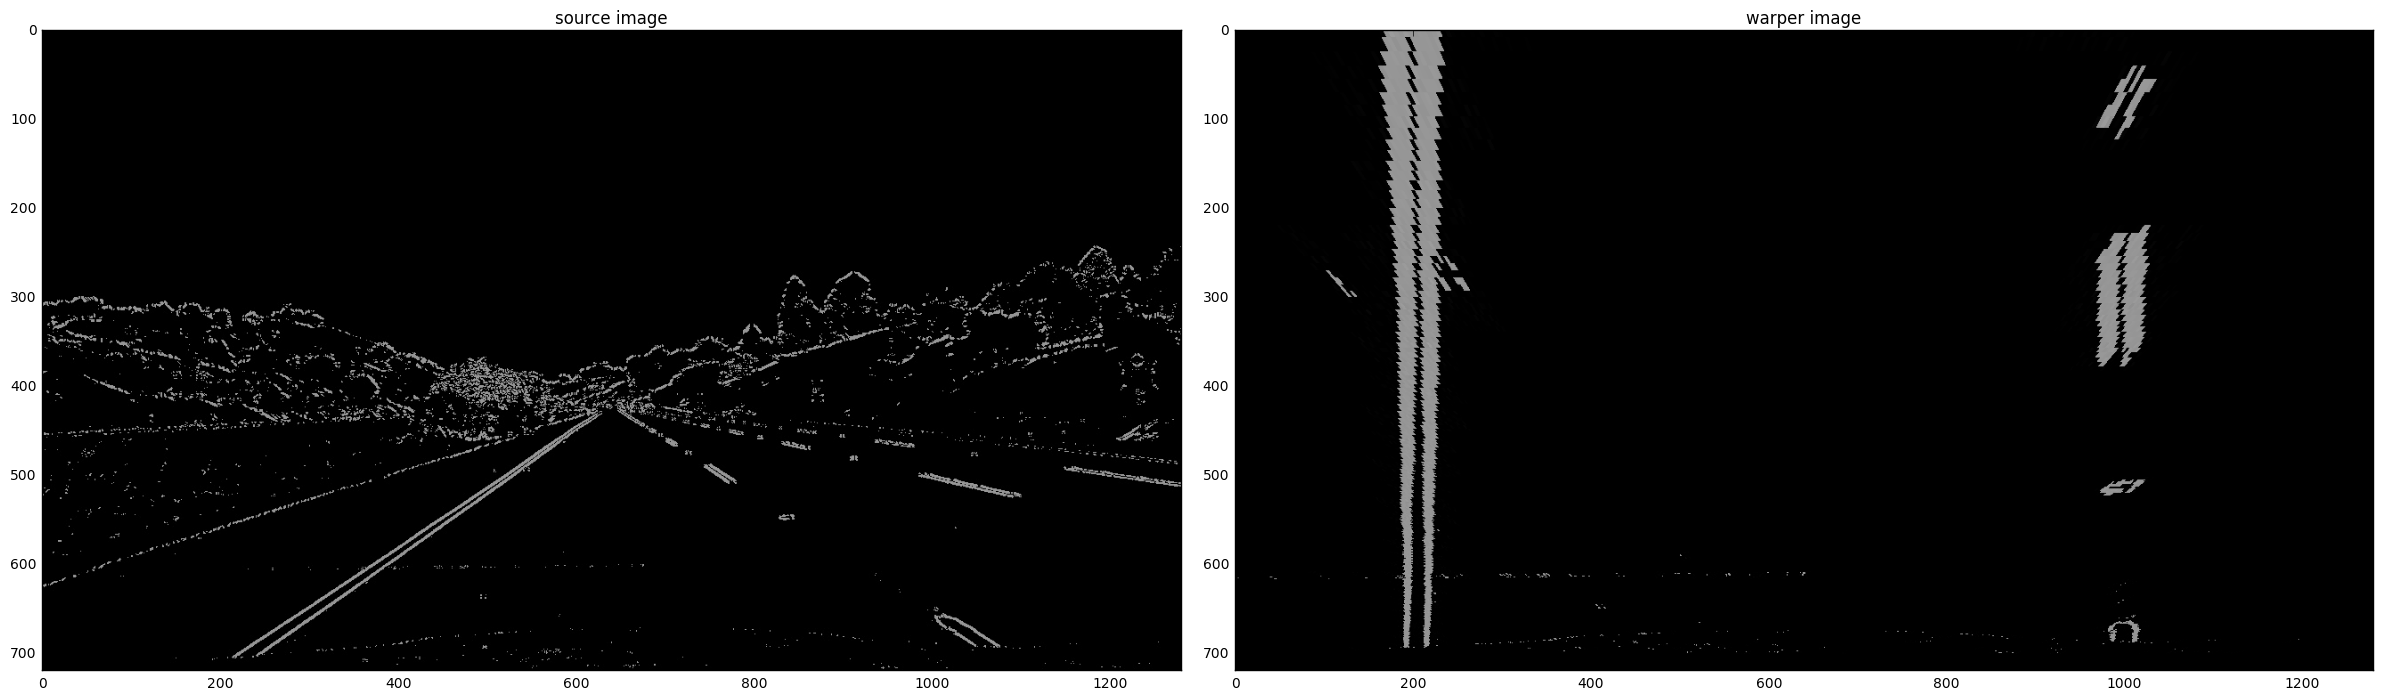

In [25]:
# Another example
leftupperpoint = [568,470]
rightupperpoint = [717,470]
leftlowerpoint = [260,680]
rightlowerpoint = [1043,680]

def warper(img):    
    src = np.float32([[leftupperpoint],[leftlowerpoint],[rightupperpoint],[rightlowerpoint]])
    dst = np.float32([[200,0],[200,680],[1000,0],[1000,680]])

    img_size = (img.shape[1], img.shape[0])    
    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

warp2 = warper(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()



ax1.set_title('source image')
ax1.imshow(image)
ax2.set_title('warper image')
ax2.imshow(warp2)

In [ ]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
mid_vertical = 0.5 * img.shape[0] * 0.5
mid_horiz_width = 0.5 * img.shape[1] * 0.5
mid_offset = 0.5 * img.shape[0] / img.shape[1]

print('mid_offset: ', mid_offset)
print('mid_horiz_width :', mid_horiz_width)
print('mid_vertical: ', mid_vertical)

In [ ]:
src = np.float32([img.shape[1]*(0.5 * mid_width/2), img.shape[0]*height_pct], 
                 [img.shape[1] * (0.5 * mid_width/2), img.shape[0]]*height_pct)

##### Method 2

If you have a binary image, you can extract the coordinates of non-zero pixels inside a window of shape (rows, cols) and top-left corner at position (i, j) like this:

* Extract the region of the binary image contained by the window (this can be done easily in numpy using slice indexing);
* Use function numpy.indices to create a pair of arrays containing the coordinates of every pixel inside the extracted window;
* Create a boolean mask from the contents of the window;
* Use the boolean mask to select the coordinates of non-zero pixels from the index arrays.

In [ ]:
print('image: ', image.shape)

In [ ]:
def pixel_coordinates(binary_image, i, j, rows, cols):
    # Exctract the region of the binary image contained by the window.
    print('binary_image: ', binary_image.shape)
    print('i: ', i)
    print('j: ', j)
    print('rows: ', rows)
    print('columns: ', cols)
    
    
    m = i + rows
    n = j + cols
    
    print('m rows ', m)
    print('n cols; ', n)
    window = binary_image[i:m, j:n]

    # Create index arrays for every pixel inside the window.
    (Y, X) = np.indices((720, 1280))

    # Offset index arrays to account for the window's position inside the binary image.
    X += j
    Y += i

    # Create boolean mask.
    boolean_mask = (window > 0)

    # Select coordinates of non-zero pixels inside the window.
    return (
        X[boolean_mask],
        Y[boolean_mask]
    )

dp = pixel_coordinates(image, 0, 0, image.shape[0], image.shape[1])

In [ ]:
x = np.arange(20).reshape(5, 4)
x

In [ ]:
row, col = np.indices((2, 3))
# x[row, col]


In [ ]:
row

In [ ]:
col

In [ ]:

x